# Лабораторная работа №3

### 171-371 Ивлев Д.С.

In [108]:
def invalid_user_input(user_input, minLimit, maxLimit):
    if user_input >= minLimit and user_input <= maxLimit:
        return False
    return True


import pymysql
con = pymysql.connect('localhost', 'root', 'root', 'std_1313_lr3')


cur = con.cursor()
cur.execute("SELECT * FROM linguisticvariables WHERE name = 'sound'")


rows = cur.fetchall()
for row in rows:   
    minLim = row[2]
    maxLim = row[3]

sound = input(f"Введите громкость телевизора от {minLim} до {maxLim} ДБ ")
while invalid_user_input(int(sound), 0, 120):
    sound = input(f"Некорректные данные! Громкость телевизора от {minLim} до {maxLim} ДБ ")


cur = con.cursor()
cur.execute("SELECT * FROM linguisticvariables WHERE name = 'brightness'")


rows = cur.fetchall()
for row in rows:   
    minLim = row[2]
    maxLim = row[3]    
    
brightness = input(f"Введите яркость телевизора от {minLim} до {maxLim} Нит ")
while invalid_user_input(int(brightness), 200, 600):
    brightness = input(f"Некорректные данные! Яркость телевизора от {minLim} до {maxLim} Нит")
    
result = f"Громкость = {sound}, Яркость = {brightness}"
print(result)

userInput = {
    'sound': int(sound),
    'brightness': int(brightness),
    'energy': 0,
}


Введите громкость телевизора от 0.0 до 120.0 ДБ 42
Введите яркость телевизора от 200.0 до 600.0 Нит 256
Громкость = 42, Яркость = 256


In [109]:
# Функции принадлежности 

def calcY(x, a, b): # S-образная
    if x <= a:
        return 0
    if x > a and x < b:
        return (x - a) / (b - a)
    if x >= b:
        return 1

def calcYzerk(x, a, b): # Z-образная
    if x <= a:
        return 1
    if x > a and x < b:
        return (b - x) / (b - a)
    if x >= b:
        return 0

def calcTrapez(x, a, b, c, d): # Трапецевидная
    if x <= a:
        return 0
    if x >= a and x <= b:
        return (x - a) / (b - a)
    if x >= b and x <= c:
        return 1
    if x >= c and x <= d:
        return (d - x) / (d - c)
    if x >= d:
        return 0

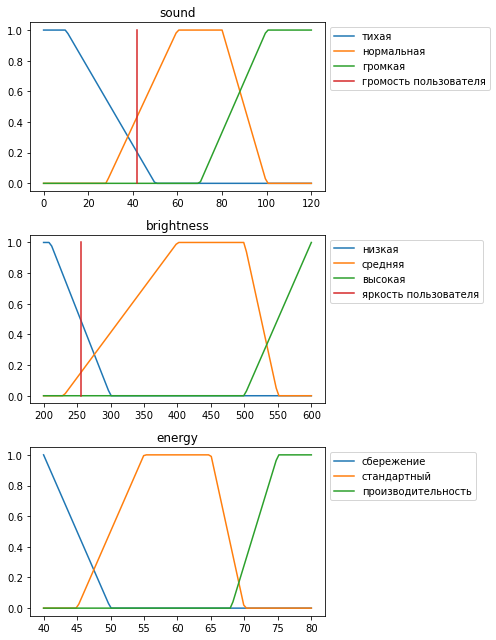

Фазификация
brightness низкая = 0.4888888888888889
sound нормальная = 0.4375
sound тихая = 0.2
brightness средняя = 0.15294117647058825
sound громкая = 0
brightness высокая = 0


In [110]:
# Фазификация

import pymysql
import matplotlib.pyplot as plt
import numpy as np


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 9))    

con = pymysql.connect('localhost', 'root', 'root', 'std_1313_lr3')


cur = con.cursor()
cur.execute("SELECT * FROM linguisticvariables")


rows = cur.fetchall()

MIN = 0
MAX = 0

varId = 0;

i = 0;

varibles = list()

for row in rows:
    varId = row[0]

    MIN = row[2]
    MAX = row[3]
    
    xRange = np.linspace(MIN, MAX, num=100)
    yRange = list()
    yZerkRange = list()
    yTrapzRange = list()
    
    
    axes[i].title.set_text(row[1])

    cur.execute(f"SELECT * FROM `fuzzyvariables` WHERE linguistic_variable_id = {varId}")

    rowsFuzzy = cur.fetchall()
    for rowFuzzy in rowsFuzzy:        
        cur.execute(f"SELECT * FROM `membershipfunctions` WHERE id = {rowFuzzy[2]}")
        rowsFunc = cur.fetchall()
        for rowFunc in rowsFunc:  
            if(rowFunc[1] == 'reversePiecewiseLinear'):
                for x in xRange:
                    yZerkRange.append(calcYzerk(x, rowFunc[2], rowFunc[3]))
                varibles.append({'nameL': row[1], 
                                 'nameF': rowFuzzy[1], 
                                 'type': rowFunc[1],
                                 'userX': userInput.get(row[1]),
                                 'userY': calcYzerk(int(userInput.get(row[1])), rowFunc[2], rowFunc[3])
                                })
                
    
                axes[i].plot(xRange, yZerkRange, label = rowFuzzy[1])
            if(rowFunc[1] == 'trapezoidal'):
                for x in xRange:
                    yTrapzRange.append(calcTrapez(x, rowFunc[2], rowFunc[3], rowFunc[4], rowFunc[5]))
                    
                varibles.append({'nameL': row[1], 
                                 'nameF': rowFuzzy[1], 
                                 'type': rowFunc[1], 
                                 'userX': userInput.get(row[1]),
                                 'userY': calcTrapez(int(userInput.get(row[1])), rowFunc[2], rowFunc[3], rowFunc[4], rowFunc[5])
                                })
                
                axes[i].plot(xRange, yTrapzRange, label = rowFuzzy[1])
            if(rowFunc[1] == 'piecewiseLinear'):
                for x in xRange:
                    yRange.append(calcY(x, rowFunc[2], rowFunc[3]))
                    
                varibles.append({'nameL': row[1], 
                                 'nameF': rowFuzzy[1], 
                                 'type': rowFunc[1],
                                 'userX': userInput.get(row[1]),
                                 'userY': calcY(int(userInput.get(row[1])), rowFunc[2], rowFunc[3])
                                })
                
                axes[i].plot(xRange, yRange, label = rowFuzzy[1])
    if(row[1] == 'sound'):
        axes[i].plot([int(sound), int(sound)], [0, 1], label = 'громость пользователя')
    if(row[1] == 'brightness'):
        axes[i].plot([int(brightness), int(brightness)], [0, 1], label = 'яркость пользователя')
    
    axes[i].legend(bbox_to_anchor=(1, 1), loc=2)    
    i = i + 1


fig.tight_layout()
plt.show()

print('Фазификация')
varibles.sort(key=lambda varibles: varibles['userY'], reverse=True)
for var in varibles:
    if(var.get('nameL') != 'energy'):
        print(f"{var.get('nameL')} {var.get('nameF')} = {var.get('userY')}")

In [111]:
#Агрегирование

import pymysql
 
con = pymysql.connect('localhost', 'root', 'root', 'std_1313_lr3')


cur = con.cursor()
cur.execute("""
SELECT once.name, threece.name, twonce.name, fource.name, fives.name, sixes.name FROM fuzzyrules 
INNER JOIN linguisticvariables once ON fuzzyrules.if_var1 = once.id 
INNER JOIN linguisticvariables twonce ON fuzzyrules.if_var2 = twonce.id 
INNER JOIN fuzzyvariables threece ON fuzzyrules.if_val1 = threece.id
INNER JOIN fuzzyvariables fource ON fuzzyrules.if_val2 = fource.id
INNER JOIN linguisticvariables fives ON fuzzyrules.then_var = fives.id 
INNER JOIN fuzzyvariables sixes ON fuzzyrules.then_val = sixes.id
""")


agrig = list()

rows = cur.fetchall()

print("ALL RULES:")
for row in rows:
    print('{0} {1} {2} {3} {4} {5}'
          .format(row[0], row[1], row[2], row[3], row[4], row[5])
         )
    print(' ')
print("---")
for row in rows:
    for var in varibles:
        if(var.get('nameL') == row[0] and var.get('nameF') == row[1]):
            for var2 in varibles:
                if(var2.get('nameL') == row[2] and var2.get('nameF') == row[3]):
                    a = var.get('userY')
                    b = var2.get('userY')
                    result = min(a, b)
                    agrig.append({
                        'nameL1': var.get('nameL'),
                        'nameF1': var.get('nameF'),
                        'nameL2': var2.get('nameL'),
                        'nameF2': var2.get('nameF'),
                        'resultAgr': result,
                        'nameL3': row[4],
                        'nameF3': row[5]
                    })
print('')
                  
agrig.sort(key=lambda agrig: agrig['resultAgr'], reverse=True)
for ag in agrig:
    print(ag)
    print('')


ALL RULES:
sound тихая brightness низкая energy сбережение
 
sound тихая brightness средняя energy стандартный
 
sound тихая brightness высокая energy стандартный
 
sound нормальная brightness низкая energy сбережение
 
sound нормальная brightness средняя energy стандартный
 
sound нормальная brightness высокая energy производительность
 
sound громкая brightness низкая energy стандартный
 
sound громкая brightness средняя energy стандартный
 
sound громкая brightness высокая energy производительность
 
---

{'nameL1': 'sound', 'nameF1': 'нормальная', 'nameL2': 'brightness', 'nameF2': 'низкая', 'resultAgr': 0.4375, 'nameL3': 'energy', 'nameF3': 'сбережение'}

{'nameL1': 'sound', 'nameF1': 'тихая', 'nameL2': 'brightness', 'nameF2': 'низкая', 'resultAgr': 0.2, 'nameL3': 'energy', 'nameF3': 'сбережение'}

{'nameL1': 'sound', 'nameF1': 'тихая', 'nameL2': 'brightness', 'nameF2': 'средняя', 'resultAgr': 0.15294117647058825, 'nameL3': 'energy', 'nameF3': 'стандартный'}

{'nameL1': 'sound', 'n

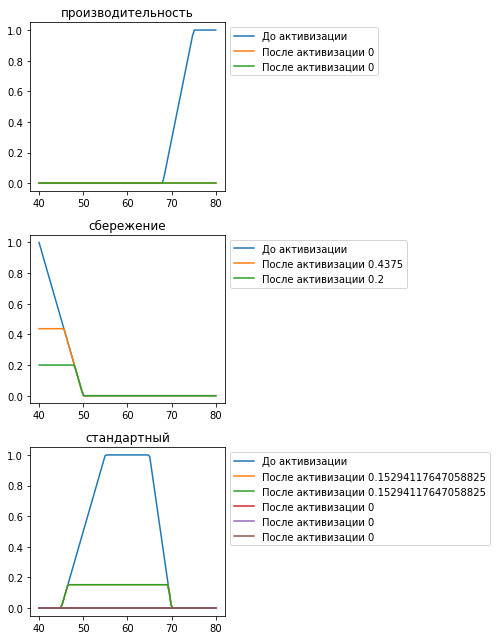

{'nameF3': 'сбережение', 'acc': 0.4375, 'type': 'reversePiecewiseLinear'}
{'nameF3': 'стандартный', 'acc': 0.15294117647058825, 'type': 'trapezoidal'}
{'nameF3': 'производительность', 'acc': 0, 'type': 'piecewiseLinear'}


In [112]:
# Активация
# min - активизация
import matplotlib.pyplot as plt1

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 9))   

        
con = pymysql.connect('localhost', 'root', 'root', 'std_1313_lr3')
cur = con.cursor()
cur.execute("SELECT * FROM `linguisticvariables` WHERE id = 3")

rows = cur.fetchall()

MIN = 0
MAX = 0

varId = 0

accumulation = []


for row in rows:
    varId = row[0]
    
    MIN = row[2]
    MAX = row[3]
    
        
    xRange = np.linspace(MIN, MAX, num=100)
    
    yRange = list()
    
    yZerkRange = list()
    
    yTrapzRange = list()
    

    cur.execute(f"SELECT * FROM `fuzzyvariables` WHERE linguistic_variable_id = {varId}")

    rowsFuzzy = cur.fetchall()
    for rowFuzzy in rowsFuzzy:
        cur.execute(f"SELECT * FROM `membershipfunctions` WHERE id = {rowFuzzy[2]}")
        rowsFunc = cur.fetchall()
        for rowFunc in rowsFunc:
            i = 0
            
            
            if(rowFunc[1] == 'piecewiseLinear'):
                for x in xRange:
                    yRange.append(calcY(x, rowFunc[2], rowFunc[3]))
                    
                axes[i].plot(xRange, yRange, label = 'До активизации')
                axes[i].title.set_text(rowFuzzy[1])
                
                
                acc1 = 0
                for var in varibles:
                    if(var.get('nameL') == row[1] and var.get('nameF') == rowFuzzy[1]):

                        for ag in agrig:
                            if(ag.get('nameL3') == row[1] and ag.get('nameF3') == rowFuzzy[1]):
                                yActiveRange = list()
                                
                                for x in xRange:
                                    yActiveRange.append(min(calcY(x, rowFunc[2], rowFunc[3]), ag.get('resultAgr')))
                            
                                axes[i].plot(xRange, yActiveRange, label = f"После активизации {ag.get('resultAgr')}")
                                
                                if ag.get('resultAgr') >= acc1:
                                    acc1 = ag.get('resultAgr')
                accumulation.append({
                    'nameF3': rowFuzzy[1],
                    'acc': acc1,
                    'type': rowFunc[1]
                })
            i = i + 1
                
            if(rowFunc[1] == 'reversePiecewiseLinear'):
                for x in xRange:
                    yZerkRange.append(calcYzerk(x, rowFunc[2], rowFunc[3]))
                    
                axes[i].plot(xRange, yZerkRange, label = 'До активизации')
                axes[i].title.set_text(rowFuzzy[1])

                
                
                acc2 = 0;
                for var in varibles:
                    
                    if(var.get('nameL') == row[1] and var.get('nameF') == rowFuzzy[1]):
                        for ag in agrig:
                            if(ag.get('nameL3') == row[1] and ag.get('nameF3') == rowFuzzy[1]):
                                yZerkActiveRange = list()
                                
                                for x in xRange:
                                    yZerkActiveRange.append(min(calcYzerk(x, rowFunc[2], rowFunc[3]), ag.get('resultAgr')))
                            
                                axes[i].plot(xRange, yZerkActiveRange, label = f"После активизации {ag.get('resultAgr')}")
                        
                                if ag.get('resultAgr') >= acc2:
                                    acc2 = ag.get('resultAgr')
                accumulation.append({
                    'nameF3': rowFuzzy[1],
                    'acc': acc2,
                    'type': rowFunc[1]
                })
            i = i + 1
            
            
            if(rowFunc[1] == 'trapezoidal'):
                for x in xRange:
                    yTrapzRange.append(calcTrapez(x, rowFunc[2], rowFunc[3], rowFunc[4], rowFunc[5]))
                
                axes[i].plot(xRange, yTrapzRange, label = 'До активизации')
                axes[i].title.set_text(rowFuzzy[1])

                
                acc3 = 0
                for var in varibles:
                    
                    if(var.get('nameL') == row[1] and var.get('nameF') == rowFuzzy[1]):
                        for ag in agrig:
                            if(ag.get('nameL3') == row[1] and ag.get('nameF3') == rowFuzzy[1]):
                            
                                yTrapzActiveRange = list()
                                
                                for x in xRange:
                                    yTrapzActiveRange.append(min(calcTrapez(x, rowFunc[2], rowFunc[3], rowFunc[4], rowFunc[5]), ag.get('resultAgr')))
                            
                                
                                axes[i].plot(xRange, yTrapzActiveRange, label = f"После активизации {ag.get('resultAgr')}")
                                if ag.get('resultAgr') >= acc3:
                                    acc3 = ag.get('resultAgr')
                accumulation.append({
                    'nameF3': rowFuzzy[1],
                    'acc': acc3,
                    'type': rowFunc[1]
                })
            i = i + 1
               
                
                 
                

axes[0].legend(bbox_to_anchor=(1, 1), loc=2)
axes[1].legend(bbox_to_anchor=(1, 1), loc=2)
axes[2].legend(bbox_to_anchor=(1, 1), loc=2)


fig.tight_layout()
plt.show()

for accum in accumulation:
    print(accum)

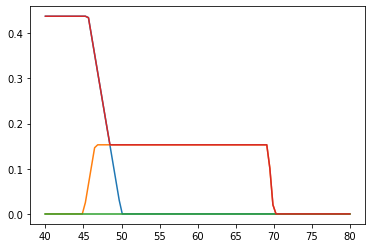

In [113]:
# Аккамулирование

# процесс нахождения функции принадлежности для выходной лингвистической переменной

# Цель аккумуляции состоит в объединении всех степеней истинности подзаключений для получения функции принадлежности
# Результат аккумуляции определяется как объединение нечетких множеств всех подзаключений нечеткой базы правил 
# относительно соответствующей лингвистической переменной

# Объединение функций принадлежности всех подзаключений проводится как правило классически (max-объединение)
    
    
import matplotlib.pyplot as plt2


        
con = pymysql.connect('localhost', 'root', 'root', 'std_1313_lr3')
cur = con.cursor()
cur.execute("SELECT * FROM `linguisticvariables` WHERE id = 3")

rows = cur.fetchall()
for row in rows:   
    minLim = row[2]
    maxLim = row[3]

MIN = 0
MAX = 0

varId = 0

resultUpLin = list()
resultUpZer = list()
resultUpTrapz = list()

xRange = np.linspace(minLim, maxLim, num=100)

def mPrinadlez(x):
    result1 = 0
    result2 = 0
    result3 = 0
    if(rowFunc[1] == 'piecewiseLinear'):
        result1 = min(calcY(x, rowFunc[2], rowFunc[3]), accValue)
    if(rowFunc[1] == 'reversePiecewiseLinear'):
        result2 = min(calcYzerk(x, rowFunc[2], rowFunc[3]), accValue)
    if(rowFunc[1] == 'trapezoidal'):
        result3 = min(calcTrapez(x, rowFunc[2], rowFunc[3], rowFunc[4], rowFunc[5]), accValue)

    return max(result1, result2, result3)
    

for row in rows:
    varId = row[0]

    MIN = row[2]
    MAX = row[3]


    cur.execute(f"SELECT * FROM `fuzzyvariables` WHERE linguistic_variable_id = {varId}")

    rowsFuzzy = cur.fetchall()
    for rowFuzzy in rowsFuzzy:
        cur.execute(f"SELECT * FROM `membershipfunctions` WHERE id = {rowFuzzy[2]}")
        rowsFunc = cur.fetchall()
        for rowFunc in rowsFunc:
            if(rowFunc[1] == 'piecewiseLinear'):
                accValue = 0
                for accum in accumulation:
                    if accum.get('type') == 'piecewiseLinear':
                        accValue = accum.get('acc')

                for xLin in xRange:
                    resultUpLin.append(mPrinadlez(xLin))
                plt2.plot(xRange,
                    resultUpLin, label = rowFuzzy[1])
                


            if(rowFunc[1] == 'reversePiecewiseLinear'):
                accValue = 0
                for accum in accumulation:
                    if accum.get('type') == 'reversePiecewiseLinear':
                        accValue = accum.get('acc')

                for xLin in xRange:
                    resultUpZer.append(mPrinadlez(xLin))
                plt2.plot(xRange,
                    resultUpZer, label = rowFuzzy[1])
                


            if(rowFunc[1] == 'trapezoidal'):
                accValue = 0
                for accum in accumulation:
                    if accum.get('type') == 'trapezoidal':
                        accValue = accum.get('acc')

                for xLin in xRange:
                    resultUpTrapz.append(mPrinadlez(xLin))
                plt2.plot(xRange,
                    resultUpTrapz, label = rowFuzzy[1])

resultYlist = list()

for i in range(len(xRange)):
    result = max(resultUpZer[i], resultUpTrapz[i], resultUpLin[i])
    resultYlist.append(result)
plt2.plot(xRange, resultYlist)
plt2.show()

In [114]:
# Дефазификация

resultYlist = list()

for i in range(len(xRange)):
    result = max(resultUpZer[i], resultUpTrapz[i], resultUpLin[i])
    resultYlist.append(result)


resultForUser = 0
resultUserUp = 0
resultUserDown = 0
for i in range(len(xRange)):
    resultUserUp = resultUserUp + (xRange[i] * resultYlist[i])
    resultUserDown = resultUserDown +  resultYlist[i]
    
    
resultForUser = resultUserUp / resultUserDown
print('Итоговое значение = ', resultForUser)

Итоговое значение =  51.206501082516965
